# DML ATE Example

This notebook covers scenario:
| Is RCT        | Treatment | Outcome    | EDA | Estimands | Refutation |
|---------------|-----------|------------|-----|-----------|------------|
| Observational | Binary    | Continuous | Yes | ATE       | Yes        |

We will estimate Average Treatment Effect (ATE) of binary treatment on continuous outcome. It shows explonatary data analysis and refutation tests

## Generate data

Let's generate data of how feature (Treatment) impact on ARPU (Outcome) with linear effect (theta) = 1.8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from causalis.data import CausalDatasetGenerator, CausalData

# Reproducibility
np.random.seed(42)

confounder_specs = [
    {"name": "tenure_months", "dist": "normal", "mu": 24, "sd": 12},
    {"name": "avg_sessions_week", "dist": "normal", "mu": 5, "sd": 2},
    {"name": "spend_last_month", "dist": "uniform", "a": 0, "b": 200},
    {"name": "premium_user", "dist": "bernoulli", "p": 0.25},
    {"name": "urban_resident", "dist": "bernoulli", "p": 0.60},
]

# Causal effect and noise
theta = 1.8  # ATE: +1.8 ARPU units if new_feature = 1
sigma_y = 3.5  # ARPU noise std
target_t_rate = 0.35  # ~35% treated

# Effects of confounders on ARPU (baseline, additive)
# Order: tenure_months, avg_sessions_week, spend_last_month, premium_user, urban_resident
beta_y = np.array([
    0.05,  # tenure_months: small positive effect
    0.40,  # avg_sessions_week: strong positive effect
    0.02,  # spend_last_month: recent spend correlates with ARPU
    2.00,  # premium_user: premium users have higher ARPU
    1.00,  # urban_resident: urban users slightly higher ARPU
], dtype=float)

# Effects of confounders on treatment assignment (log-odds scale)
beta_t = np.array([
    0.015,  # tenure_months
    0.10,  # avg_sessions_week
    0.002,  # spend_last_month
    0.75,  # premium_user
    0.30,  # urban_resident: more likely to get the feature
], dtype=float)

gen = CausalDatasetGenerator(
    theta=theta,
    outcome_type="continuous",
    sigma_y=sigma_y,
    target_t_rate=target_t_rate,
    seed=42,
    confounder_specs=confounder_specs,
    beta_y=beta_y,
    beta_t=beta_t,
)


# Create dataset
causal_data = gen.to_causal_data(
    n=10000,
    confounders = [
    "tenure_months",
    "avg_sessions_week",
    "spend_last_month",
    "premium_user",
    "urban_resident",
]
)

# Show first few rows
causal_data.df.head()


,y,t,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident
0,5.927714,1.0,27.656605,5.352554,72.552568,1.0,0.0
1,11.122008,1.0,11.520191,6.798247,188.481287,1.0,0.0
2,10.580393,1.0,33.005414,2.055459,51.040440,0.0,1.0
3,6.982844,1.0,35.286777,4.429404,166.992239,0.0,1.0
4,10.899381,0.0,0.587578,6.658307,179.371126,0.0,0.0


## EDA


In [2]:
from causalis.eda import CausalEDA
eda = CausalEDA(causal_data)

# shape of data
eda.data_shape()

{'n_rows': 10000, 'n_columns': 7}

### General dataset information

Let's see how outcome differ between clients who recieved the feature and didn't

In [3]:
# 1) Outcome statistics by treatment
eda.outcome_stats()

,count,mean,std,min,p10,p25,median,p75,p90,max
treatment,,,,,,,,,,
0.0,6523,6.014033,3.926613,-9.866447,1.013702,3.427671,6.041249,8.683796,10.958614,20.770359
1.0,3477,8.549418,3.933790,-5.507710,3.517233,5.908059,8.562984,11.207439,13.603630,21.377687


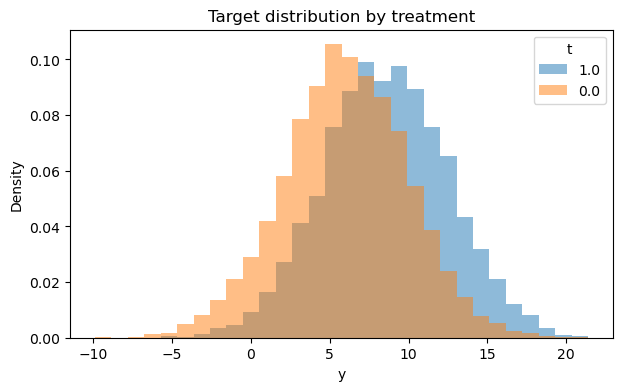

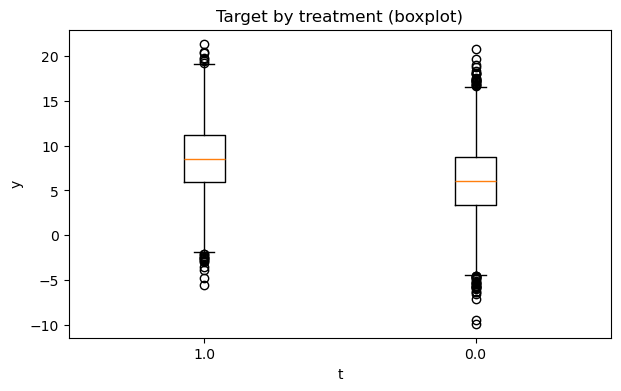

In [4]:
# 2) Outcome distribution by treatment (hist + boxplot)
fig1, fig2 = eda.outcome_plots()
plt.show()

### Propensity

Now let's examine how propensity score differ treatments

In [5]:
# Shows means of confounders for control/treated groups, absolute differences, and SMD values
confounders_balance_df = eda.confounders_means()
display(confounders_balance_df)

,mean_t_0,mean_t_1,abs_diff,smd
confounders,,,,
premium_user,0.198682,0.347426,0.148744,0.338573
avg_sessions_week,4.908586,5.288561,0.379975,0.190228
tenure_months,23.174130,25.195619,2.021489,0.167898
urban_resident,0.577802,0.644234,0.066432,0.136568
spend_last_month,97.786313,105.308510,7.522196,0.130139


In [6]:
# Propensity model fit
ps_model = eda.fit_propensity()

# ROC AUC - shows how predictable treatment is from confounders
roc_auc_score = ps_model.roc_auc
print("ROC AUC from PropensityModel:", round(roc_auc_score, 4))

ROC AUC from PropensityModel: 0.6052


In [7]:
# Positivity check - assess overlap between treatment groups
positivity_result = ps_model.positivity_check()
print("Positivity check from PropensityModel:", positivity_result)

Positivity check from PropensityModel: {'bounds': (0.05, 0.95), 'share_below': 0.001, 'share_above': 0.0, 'flag': False}


In [8]:
# SHAP values - feature importance for treatment assignment from confounders
shap_values_df = ps_model.shap
display(shap_values_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed
0,num__spend_last_month,-0.000304,0.165514,1.179999,0.038370,-0.000069
1,num__avg_sessions_week,0.000255,0.196429,1.217049,0.045715,0.000058
2,num__urban_resident,-0.000109,0.149617,1.161390,0.034613,-0.000025
3,num__premium_user,0.000100,0.300758,1.350882,0.070847,0.000023
4,num__tenure_months,0.000058,0.177304,1.193994,0.041165,0.000013


In [9]:
# If your DataFrame has a 'shap_mean' column:
shap_df = shap_values_df.copy()
shap_df['mean_abs_shap'] = shap_df['shap_mean'].abs()
shap_df.sort_values('mean_abs_shap', ascending=False, inplace=True)
display(shap_df)

,feature,shap_mean,shap_mean_abs,odds_mult_abs,exact_pp_change_abs,exact_pp_change_signed,mean_abs_shap
0,num__spend_last_month,-0.000304,0.165514,1.179999,0.038370,-0.000069,0.000304
1,num__avg_sessions_week,0.000255,0.196429,1.217049,0.045715,0.000058,0.000255
2,num__urban_resident,-0.000109,0.149617,1.161390,0.034613,-0.000025,0.000109
3,num__premium_user,0.000100,0.300758,1.350882,0.070847,0.000023,0.000100
4,num__tenure_months,0.000058,0.177304,1.193994,0.041165,0.000013,0.000058


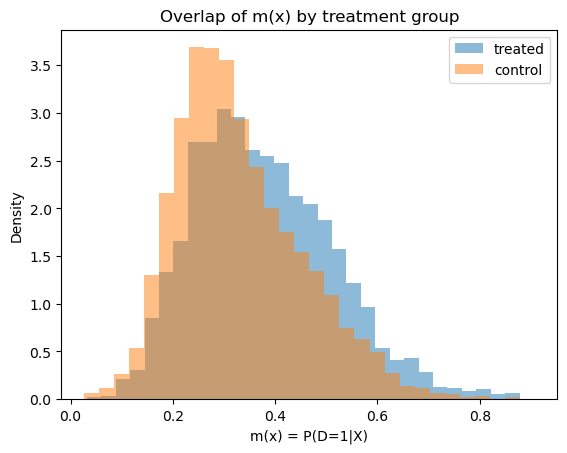

In [10]:
# Propensity score overlap graph
ps_model.ps_graph()
plt.show()

### Outcome regression

Let's analyze how confounders predict outcome

In [11]:
# Outcome model fit
outcome_model = eda.outcome_fit()

# RMSE and MAE of regression model
print(outcome_model.scores)

{'rmse': 3.6910736220288642, 'mae': 2.939833306169571}


In [12]:
# 2) SHAP values - feature importance for outcome prediction from confounders
shap_outcome_df = outcome_model.shap
display(shap_outcome_df)

,feature,shap_mean
0,tenure_months,-0.001717
1,avg_sessions_week,0.000814
2,premium_user,0.000805
3,spend_last_month,0.000376
4,urban_resident,-0.000277


## Inference

Now time to estimate ATE with Double Machine Learning

In [13]:
from causalis.inference.ate import dml_ate

# Estimate Average Treatment Effect (ATE)
ate_result = dml_ate(causal_data, n_folds=4, confidence_level=0.95)

In [14]:
ate_result

{'coefficient': 1.7837568133024586,
 'std_error': 0.08796851810878961,
 'p_value': 0.0,
 'confidence_interval': (1.6113416860358714, 1.9561719405690459),
 'model': <causalkit.inference.estimators.irm.IRM at 0x1492070e0>}

True theta in our data generating proccess was 1.8

## Refutation

### Placebo

In [15]:
# Import refutation utilities
from causalis.refutation import (
    refute_placebo_outcome,
    refute_placebo_treatment,
    refute_subset,
    refute_irm_orthogonality,
    sensitivity_analysis,
    sensitivity_analysis_set
)

Replacing outcome with dummy random variable must broke our model and effect will be near zero

In [16]:
# Replacing an outcome with placebo
ate_placebo_outcome = refute_placebo_outcome(
    dml_ate,
    causal_data,
    random_state=42
)

print(ate_placebo_outcome)

{'theta': -0.0078040951760904075, 'p_value': 0.39168288447854893}


Replacing treatment with dummy random variable must broke our model and effect will be near zero

In [17]:
# Replacing treatment with placebo
ate_placebo_treatment = refute_placebo_treatment(
    dml_ate,
    causal_data,
    random_state=42
)

print(ate_placebo_treatment)

{'theta': 0.03991094217663553, 'p_value': 0.6437714720309031}


Let's chanllege our dataset and romove random parts. Theta shoul be near estimated

In [18]:
# Inference on subsets
subset_fractions = [0.3, 0.5]

ate_subset_results = []
for fraction in subset_fractions:
    subset_result = refute_subset(
        dml_ate,
        causal_data,
        fraction=fraction,
        random_state=42
    )
    ate_subset_results.append(subset_result)

    print(f" With {fraction*100:.0f}% subset: theta = {subset_result['theta']:.4f}, p_value = {subset_result['p_value']:.4f}")

 With 30% subset: theta = 1.5859, p_value = 0.0000
 With 50% subset: theta = 1.8288, p_value = 0.0000


### Orthogonality

Orthogonality tests show us "Does we correct specify the model"

In [19]:
ate_ortho_check = refute_irm_orthogonality(dml_ate, causal_data)

/var/folders/m0/gys_jqqj44n801p04bgv_ct00000gn/T/ipykernel_28797/1147422044.py:1: DeprecationWarning: 'clip_eps' is deprecated; use 'trimming_threshold'.
  ate_ortho_check = refute_irm_orthogonality(dml_ate, causal_data)


In [20]:
# 1. Out-of-sample moment check
print("\n--- 1. Out-of-Sample Moment Check ---")
oos_test = ate_ortho_check['oos_moment_test']
print(f"T-statistic: {oos_test['tstat']:.4f}")
print(f"P-value: {oos_test['pvalue']:.4f}")
print(f"Interpretation: {oos_test['interpretation']}")
print("\nFold-wise results:")
display(oos_test['fold_results'])



--- 1. Out-of-Sample Moment Check ---
T-statistic: 0.4923
P-value: 0.6225
Interpretation: Should be ≈ 0 if moment condition holds

Fold-wise results:


,fold,n,psi_mean,psi_var
0,0,2500,0.140046,75.991733
1,1,2500,0.172414,77.675004
2,2,2500,-0.066878,69.722917
3,3,2500,-0.076579,71.176671


psi_mean is near zero on every fold, so the test is successful

In [21]:
# 2. Orthogonality derivatives
print("\n--- 2. Orthogonality (Gateaux Derivative) Tests ---")
ortho_derivs = ate_ortho_check['orthogonality_derivatives']
print(f"Interpretation: {ortho_derivs['interpretation']}")

print("\nFull sample derivatives:")
display(ortho_derivs['full_sample'])

print("\nTrimmed sample derivatives:")
display(ortho_derivs['trimmed_sample'])

if len(ortho_derivs['problematic_full']) > 0:
    print("\n⚠ PROBLEMATIC derivatives (full sample):")
    display(ortho_derivs['problematic_full'])
else:
    print("\n✓ No problematic derivatives in full sample")

if len(ortho_derivs['problematic_trimmed']) > 0:
    print("\n⚠ PROBLEMATIC derivatives (trimmed sample):")
    display(ortho_derivs['problematic_trimmed'])
else:
    print("\n✓ No problematic derivatives in trimmed sample")



--- 2. Orthogonality (Gateaux Derivative) Tests ---
Interpretation: Large |t| (>2) indicate calibration issues

Full sample derivatives:


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m
0,0,-0.059500,0.016515,-3.602854,0.020506,0.008181,2.506691,-0.359189,0.398015,-0.902452
1,1,0.008439,0.018789,0.449139,0.008293,0.008950,0.926599,-0.639525,0.543632,-1.176393
2,2,0.020546,0.017640,1.164703,0.006927,0.008936,0.775167,0.126057,0.556254,0.226617
3,3,0.002475,0.016398,0.150957,-0.001440,0.008675,-0.165993,-0.037181,0.441771,-0.084164
4,4,0.001852,0.013692,0.135296,0.012502,0.010076,1.240750,-0.021918,0.318157,-0.068892
5,5,0.013815,0.017182,0.804053,0.002671,0.007965,0.335414,0.219591,0.440190,0.498856



Trimmed sample derivatives:


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m
0,0,-0.059500,0.016515,-3.602854,0.020506,0.008181,2.506691,-0.359189,0.398015,-0.902452
1,1,0.008439,0.018789,0.449139,0.008293,0.008950,0.926599,-0.639525,0.543632,-1.176393
2,2,0.020546,0.017640,1.164703,0.006927,0.008936,0.775167,0.126057,0.556254,0.226617
3,3,0.002475,0.016398,0.150957,-0.001440,0.008675,-0.165993,-0.037181,0.441771,-0.084164
4,4,0.001852,0.013692,0.135296,0.012502,0.010076,1.240750,-0.021918,0.318157,-0.068892
5,5,0.013815,0.017182,0.804053,0.002671,0.007965,0.335414,0.219591,0.440190,0.498856



⚠ PROBLEMATIC derivatives (full sample):


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m
0,0,-0.0595,0.016515,-3.602854,0.020506,0.008181,2.506691,-0.359189,0.398015,-0.902452



⚠ PROBLEMATIC derivatives (trimmed sample):


,basis,d_g1,se_g1,t_g1,d_g0,se_g0,t_g0,d_m,se_m,t_m
0,0,-0.0595,0.016515,-3.602854,0.020506,0.008181,2.506691,-0.359189,0.398015,-0.902452


t_m1, t_m0, t_g should be above 2.
Even after trimming our data t_m1, t_m0, t_g above 2 across all confounders

In [22]:
# 3. Influence diagnostics
print("\n--- 3. Influence Diagnostics ---")
influence = ate_ortho_check['influence_diagnostics']
print(f"Interpretation: {influence['interpretation']}")

print("\nFull sample influence metrics:")
print(f"  Plugin SE: {influence['full_sample']['se_plugin']:.4f}")
print(f"  Kurtosis: {influence['full_sample']['kurtosis']:.2f}")
print(f"  P99/Median ratio: {influence['full_sample']['p99_over_med']:.2f}")

print("\nTrimmed sample influence metrics:")
print(f"  Plugin SE: {influence['trimmed_sample']['se_plugin']:.4f}")
print(f"  Kurtosis: {influence['trimmed_sample']['kurtosis']:.2f}")
print(f"  P99/Median ratio: {influence['trimmed_sample']['p99_over_med']:.2f}")

print("\nTop influential observations (full sample):")
display(influence['full_sample']['top_influential'])



--- 3. Influence Diagnostics ---
Interpretation: Heavy tails or extreme kurtosis suggest instability

Full sample influence metrics:
  Plugin SE: 0.0858
  Kurtosis: 10.47
  P99/Median ratio: 6.90

Trimmed sample influence metrics:
  Plugin SE: 0.0858
  Kurtosis: 10.47
  P99/Median ratio: 6.90

Top influential observations (full sample):


,i,psi,m,res_t,res_c
0,9368,-84.362039,0.081674,-6.769493,-0.000000
1,7299,-76.682519,0.112310,-8.863792,-0.000000
2,4732,-75.571748,0.840977,0.000000,12.231674
3,874,68.376059,0.091496,6.664251,0.000000
4,3122,67.284889,0.065985,4.472299,0.000000
5,5563,65.500549,0.144684,9.980117,0.000000
6,4273,63.943012,0.143024,9.029281,0.000000
7,1446,-61.722358,0.863437,0.000000,8.704858
8,6057,58.460959,0.161539,9.430154,0.000000
9,8234,52.419202,0.083391,4.438301,0.000000


In [23]:
# Trimming information
print("\n--- Propensity Score Trimming ---")
trim_info = ate_ortho_check['trimming_info']
print(f"Trimming bounds: {trim_info['bounds']}")
print(f"Observations trimmed: {trim_info['n_trimmed']} ({trim_info['pct_trimmed']:.1f}%)")



--- Propensity Score Trimming ---
Trimming bounds: (0.02, 0.98)
Observations trimmed: 0 (0.0%)


In this test we analyze distribution of theta before trimming and after. There is no big difference. So test passed

In [24]:
# Diagnostic conditions breakdown
print("\n--- Diagnostic Conditions Assessment ---")
conditions = ate_ortho_check['diagnostic_conditions']

print("Individual condition checks:")
for condition, passed in conditions.items():
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {condition}: {status}")

print(f"\nOverall: {ate_ortho_check['overall_assessment']}")



--- Diagnostic Conditions Assessment ---
Individual condition checks:
  oos_moment_ok: ✓ PASS
  derivs_full_ok: ✗ FAIL
  derivs_trim_ok: ✗ FAIL
  se_reasonable: ✓ PASS
  no_extreme_influence: ✓ PASS
  trimming_reasonable: ✓ PASS

Overall: CAUTION: Most conditions satisfied


### Sensitivity analysis

Let's analyze how unobserved confounder could look

In [25]:
bench_sets = causal_data.confounders
res = sensitivity_analysis_set(
    ate_result,
    benchmarking_set=bench_sets,
    level=0.95,
    null_hypothesis=0.0,
)

In [26]:
# Build a DataFrame with confounders as rows and the metrics as columns
summary_df = pd.DataFrame({
    name: (df.loc['t'] if 't' in df.index else df.iloc[0])
    for name, df in res.items()
}).T


In [29]:
summary_df

,CI lower,theta lower,theta,theta upper,CI upper
tenure_months,1.611342,1.770011,1.783757,1.797503,1.956172
avg_sessions_week,1.611342,1.768202,1.783757,1.799312,1.956172
spend_last_month,1.611342,1.773033,1.783757,1.794480,1.956172
premium_user,1.611342,1.755566,1.783757,1.811948,1.956172
urban_resident,1.611342,1.772618,1.783757,1.794896,1.956172


It is business domain and data knowledge relative question. In this situation we will stop on the most influential confounder 'premium_user' and test theta when we do not observe anothere confounder with strength of 'premium_user'

In [28]:
# Run sensitivity analysis on our ATE result
sensitivity_report_1 = sensitivity_analysis(
    ate_result,
    cf_y=0.06,  # Confounding strength affecting outcome
    cf_d=0.03,  # Confounding strength affecting treatment
    rho=1.0     # Perfect correlation between unobserved confounders
)

print(sensitivity_report_1)

================== Sensitivity Analysis ==================

------------------ Scenario          ------------------
Significance Level: level=0.95
Sensitivity parameters: cf_y=0.06; cf_d=0.03, rho=1.0

------------------ Bounds with CI    ------------------
          CI lower  theta lower           theta  theta upper      CI upper
     t    1.611342     1.463349        1.783757     2.104165      1.956172

------------------ Robustness Values ------------------
          H_0    RV (%)  RVa (%)
     t    0.0  4.699863 0.000000


CI lower >> 0. It means test is passed